# Pack: schema_zoo

**Goal:** Practice robust schema inference, nested flattening, indexing/selection, and plotting.

## Closed-ended tasks
1) **Schema profile**: total `rows`, `unique_ids`, and `id_collision_count` (same id with conflicting payloads).
2) **Missingness plot**: create a bar chart of top-15 keys by presence rate and save as `schema_missingness.html`.
3) **Tags**: flatten any tag fields (either `meta.tags` list or `meta=[{k:'tag',v:...}]`) and produce a bar chart of top tags saved as `top_tags.html`.
4) **Counts**: output `top_tag_counts` (top 5 as a dict) and `keys_multi_type_count` (keys that appear with more than one JSON type).

## What to output
Create `result.json` with:
```
{
  "rows": int,
  "unique_ids": int,
  "id_collision_count": int,
  "top_tag_counts": {"tag": count, ...},   # top 5
  "keys_present_top10": {"key": count, ...}, # optional, not graded
  "keys_multi_type_count": int
}
```
Also save plots:
- `schema_missingness.html`
- `top_tags.html`


In [37]:
import pandas as pd
import json
from pathlib import Path
answer = {}

In [38]:
json_files = Path("./").glob("schema*json*")
dfs = []
for file in json_files:
    try:
        df = pd.read_json(file)
        dfs.append(df)
    except Exception as e:
        try:
            df = pd.read_json(file, lines=True)
            dfs.append(df)
        except Exception as f:
            print("f", f)
df = pd.concat(dfs)
df = df.reset_index(drop=True)

In [39]:
len(df)

2384

1) **Schema profile**: total `rows`, `unique_ids`, and `id_collision_count` (same id with conflicting payloads).

In [40]:
n_rows = len(df)
unique_ids = df.id.nunique()
id_collision_count = n_rows - unique_ids
n_rows, unique_ids, id_collision_count
answer["rows"] = n_rows
answer["unique_ids"] = unique_ids
answer["id_collision_count"] = id_collision_count

2) **Missingness plot**: create a bar chart of top-15 keys by presence rate and save as `schema_missingness.html`.

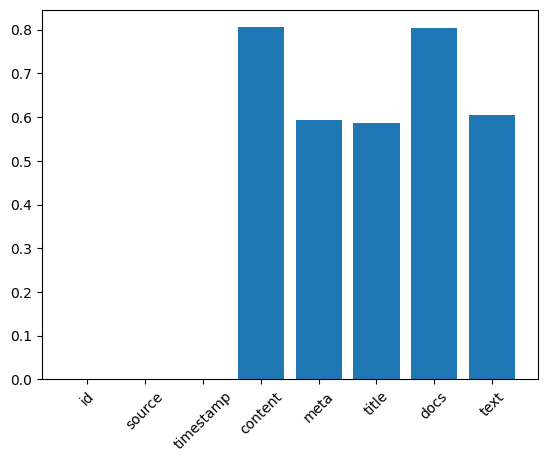

In [41]:
from matplotlib import pyplot as plt
import mpld3
def get_presence_rate(series):
    return 1 - (series.notna().sum() / len(series))

presence_rates = df.agg(get_presence_rate)
plt.bar(presence_rates.index, presence_rates.values)
# whats the one to rotate the x axis values...
plt.xticks(rotation=45)
mpld3.save_html(plt.gcf(), "schema_missingness.html")

3) **Tags**: flatten any tag fields (either `meta.tags` list or `meta=[{k:'tag',v:...}]`) and produce a bar chart of top tags saved as `top_tags.html`.

In [42]:
keys = set()
def process_meta(meta):
    # first try to read it in
    if not meta or isinstance(meta, float) and pd.isna(meta):
        return []
    # print(meta)
    tags = []
    if 'tags' in meta and meta.get('tags') and isinstance(meta['tags'], list):
        # print('here', meta['tags'])
        tags = meta['tags']
    elif meta and isinstance(meta, list):
        tags = [item['v'] for item in meta if item['k'] == 'tag']
        k_unique = set([item['k'] for item in meta])
        keys.update(k_unique)
    else:
        print("what")
    return tags
    # pass

df['tags'] = df.meta.apply(process_meta)
keys

{'tag'}

In [43]:
# we need to get a counter of the tags
from collections import Counter
tags = []
df['tags'].apply(lambda x: tags.extend(x))
c = Counter(tags)

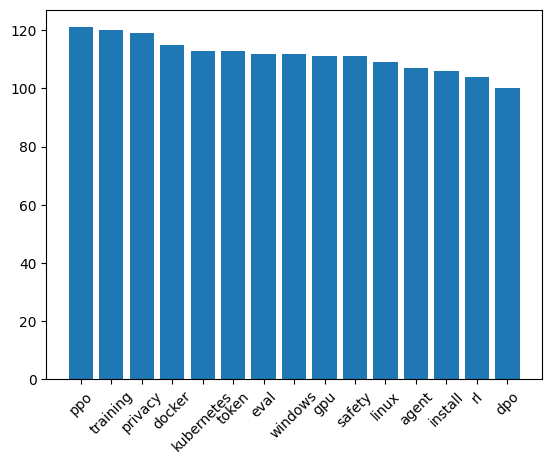

In [44]:
import mpld3
top_tags = c.most_common(15)
indices = [tag for tag, _ in top_tags]
values = [val for _, val in top_tags]
plt.bar(x=indices, height=values)
plt.xticks(rotation=45)
mpld3.save_html(plt.gcf(), "top_tags.html")

4) **Counts**: output `top_tag_counts` (top 5 as a dict) and `keys_multi_type_count` (keys that appear with more than one JSON type).

In [45]:
top_5 = c.most_common(5)
top_5
#   "top_tag_counts": {"tag": count, ...},   # top 5

[('ppo', 121),
 ('training', 120),
 ('privacy', 119),
 ('docker', 115),
 ('kubernetes', 113)]

In [46]:
top_tag_counts = {t:c for t,c in top_5}
top_tag_counts
answer["top_tag_counts"] = top_tag_counts


In [47]:
from pathlib import Path
import gzip
import json

from json import JSONDecodeError
rows = []
json_files = Path("./").glob("schema*json*")
for file in json_files:
    if file.suffix == '.gz':
        opener = gzip.open(file, mode = "rt")
    else:
        opener = open(file, mode = "rt")
    with opener as f:
        content = f.read()

    # try json read
    try:
        loaded = json.loads(content)
        if isinstance(loaded, list):
            rows.extend(loaded)
        else:
            # dict object
            rows.append(loaded)
        continue
    except JSONDecodeError:
        pass
    
    # if we are here we failed, lets try jsonl

    for line in content.splitlines():
        if line.strip():
            try:
                loaded = json.loads(line)
                rows.extend(loaded if isinstance(loaded, list) else [loaded])
            except JSONDecodeError:
                pass
# iterate through each of the keys and see if there are mixed data types
keys = set()
for idx, row in enumerate(rows):
    # print(row, idx)
    row_keys = set(row.keys())
    keys.update(row_keys)

all_keys = keys # {'content', 'docs', 'id', 'meta', 'source', 'text', 'timestamp', 'title'}
keys_dtype = {k: [] for k in all_keys}

for idx, row in enumerate(rows):
    # key -> type pairs
    for k in row.keys():
        if type(row[k]) not in keys_dtype[k]:
            keys_dtype[k].append(type(row[k]))

keys_multi_type_count = sum([1 for _, val in keys_dtype.items() if len(val) > 1])
answer['keys_multi_type_count'] = keys_multi_type_count

In [48]:
answer

{'rows': 2384,
 'unique_ids': 2285,
 'id_collision_count': 99,
 'top_tag_counts': {'ppo': 121,
  'training': 120,
  'privacy': 119,
  'docker': 115,
  'kubernetes': 113},
 'keys_multi_type_count': 1}

In [ ]:
# Create the four records as described
records = [
    {"id": "X", "v": 1},
    {"id": "X", "v": 1},  # identical to above
    {"id": "X", "v": 2},  # one true conflict
    {"id": "Y", "v": 3}
]

def collision_detect()

In [66]:
from hashlib import md5
# Create the four records as described
records = [
    {"id": "X", "v": 1},
    {"id": "X", "v": 1},  # identical to above
    {"id": "X", "v": 2},  # one true conflict
    {"id": "Y", "v": 3}
]


def compute_hash(row):
    content = {k: str(row[k]) for k in row.index if k != "id"}
    digest = md5(json.dumps(content).encode()).hexdigest()
    return digest


df = pd.DataFrame(records)
df['hash'] = df.apply(compute_hash, axis=1)
(df.groupby('id')['hash'].nunique() > 1).sum()

np.int64(1)

In [67]:
df

,id,v,hash
0,X,1,80cbbbfbc5ba78bc178020dbef9a36d5
1,X,1,80cbbbfbc5ba78bc178020dbef9a36d5
2,X,2,757bde3e146d6e8e748909e603eff62f
3,Y,3,5f83aec22273fc6aa5203daf53f8c4aa
